**1. Giải thích vì sao khi dùng Naive-Learning thì xe taxi chỉ đứng yên một chỗ?**

**Trả lời:** Naive-Learning ý tưởng chính là việc lựa chọn một action dẫn đến một kết quả  "tốt" thì “có nhiều khả năng” được chọn và nếu nó dẫn đến một kết quả “xấu” thì nó ít có khả năng được chọn hơn. Taxi vẫn có di chuyển khi vì quá trình khởi tạo có thể khiến xe rơi vào vị trí ngõ cụt, reward vẫn được nhận cho action này. Điều này bắt nguồn từ việc random các action ban đầu khiến xe thực hiện sai (đón và trả khách) nên các giá trị reward rất nhỏ dẫn đến ở các bước sau, agent sẽ không chọn các action này thay vào đó là các action di chuyển.

**2. Giải thích vì sao khi dùng Q-Leaning thì xe taxi có thể đón và trả khách được?**

**Trả lời:** Mục tiêu của Q-Learning là tìm ra các action tối ưu ở mỗi state. Q-Learning có:

- Chọn hành động tốt nhất từ Q-table (exploitation)
- Đôi khi gamble và chọn một action ngẫu nhiên (exploration)
- Nếu giá trị hiển thị bằng 0 cho tất cả các tùy chọn, hãy chọn một hành động ngẫu nhiên.
- Bắt đầu với 100% gamble (exploration),, di chuyển dần dần đến 0% (exploitation)
- Sử dụng discount rate và learning rate

Nên Q - Learning luôn có sự chênh lệch nhất định, ít trùng giá trị, dễ dàng tìm ra action tối ưu tại mỗi state.

**3.Tìm hiểu một game khác trên OpenAI và thiết lập cho agent chơi được**

**Code for training a Deep Reinforcement Learning agent to play the game of Snake**

In [ ]:
# Clone  repo
!git clone https://github.com/DragonWarrior15/snake-rl.git

Cloning into 'snake-rl'...
remote: Enumerating objects: 615, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 615 (delta 29), reused 55 (delta 19), pack-reused 543
Receiving objects: 100% (615/615), 61.10 MiB | 32.50 MiB/s, done.
Resolving deltas: 100% (311/311), done.


In [ ]:
cd '/content/snake-rl'

/content/snake-rl


In [ ]:
"""
store all the agents here
"""
from replay_buffer import ReplayBuffer, ReplayBufferNumpy
import numpy as np
import time
import pickle
from collections import deque
import json
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Softmax, MaxPool2D
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.losses import Huber

def huber_loss(y_true, y_pred, delta=1):
    """Keras implementation for huber loss
    loss = {
        0.5 * (y_true - y_pred)**2 if abs(y_true - y_pred) < delta
        delta * (abs(y_true - y_pred) - 0.5 * delta) otherwise
    }
    Parameters
    ----------
    y_true : Tensor
        The true values for the regression data
    y_pred : Tensor
        The predicted values for the regression data
    delta : float, optional
        The cutoff to decide whether to use quadratic or linear loss

    Returns
    -------
    loss : Tensor
        loss values for all points
    """
    error = (y_true - y_pred)
    quad_error = 0.5*tf.math.square(error)
    lin_error = delta*(tf.math.abs(error) - 0.5*delta)
    # quadratic error, linear error
    return tf.where(tf.math.abs(error) < delta, quad_error, lin_error)

def mean_huber_loss(y_true, y_pred, delta=1):
    """Calculates the mean value of huber loss

    Parameters
    ----------
    y_true : Tensor
        The true values for the regression data
    y_pred : Tensor
        The predicted values for the regression data
    delta : float, optional
        The cutoff to decide whether to use quadratic or linear loss

    Returns
    -------
    loss : Tensor
        average loss across points
    """
    return tf.reduce_mean(huber_loss(y_true, y_pred, delta))

class Agent():
    """Base class for all agents
    This class extends to the following classes
    DeepQLearningAgent
    HamiltonianCycleAgent
    BreadthFirstSearchAgent

    Attributes
    ----------
    _board_size : int
        Size of board, keep greater than 6 for useful learning
        should be the same as the env board size
    _n_frames : int
        Total frames to keep in history when making prediction
        should be the same as env board size
    _buffer_size : int
        Size of the buffer, how many examples to keep in memory
        should be large for DQN
    _n_actions : int
        Total actions available in the env, should be same as env
    _gamma : float
        Reward discounting to use for future rewards, useful in policy
        gradient, keep < 1 for convergence
    _use_target_net : bool
        If use a target network to calculate next state Q values,
        necessary to stabilise DQN learning
    _input_shape : tuple
        Tuple to store individual state shapes
    _board_grid : Numpy array
        A square filled with values from 0 to board size **2,
        Useful when converting between row, col and int representation
    _version : str
        model version string
    """
    def __init__(self, board_size=10, frames=2, buffer_size=10000,
                 gamma=0.99, n_actions=3, use_target_net=True,
                 version=''):
        """ initialize the agent

        Parameters
        ----------
        board_size : int, optional
            The env board size, keep > 6
        frames : int, optional
            The env frame count to keep old frames in state
        buffer_size : int, optional
            Size of the buffer, keep large for DQN
        gamma : float, optional
            Agent's discount factor, keep < 1 for convergence
        n_actions : int, optional
            Count of actions available in env
        use_target_net : bool, optional
            Whether to use target network, necessary for DQN convergence
        version : str, optional except NN based models
            path to the model architecture json
        """
        self._board_size = board_size
        self._n_frames = frames
        self._buffer_size = buffer_size
        self._n_actions = n_actions
        self._gamma = gamma
        self._use_target_net = use_target_net
        self._input_shape = (self._board_size, self._board_size, self._n_frames)
        # reset buffer also initializes the buffer
        self.reset_buffer()
        self._board_grid = np.arange(0, self._board_size**2)\
                             .reshape(self._board_size, -1)
        self._version = version

    def get_gamma(self):
        """Returns the agent's gamma value

        Returns
        -------
        _gamma : float
            Agent's gamma value
        """
        return self._gamma

    def reset_buffer(self, buffer_size=None):
        """Reset current buffer 
        
        Parameters
        ----------
        buffer_size : int, optional
            Initialize the buffer with buffer_size, if not supplied,
            use the original value
        """
        if(buffer_size is not None):
            self._buffer_size = buffer_size
        self._buffer = ReplayBufferNumpy(self._buffer_size, self._board_size, 
                                    self._n_frames, self._n_actions)

    def get_buffer_size(self):
        """Get the current buffer size
        
        Returns
        -------
        buffer size : int
            Current size of the buffer
        """
        return self._buffer.get_current_size()

    def add_to_buffer(self, board, action, reward, next_board, done, legal_moves):
        """Add current game step to the replay buffer

        Parameters
        ----------
        board : Numpy array
            Current state of the board, can contain multiple games
        action : Numpy array or int
            Action that was taken, can contain actions for multiple games
        reward : Numpy array or int
            Reward value(s) for the current action on current states
        next_board : Numpy array
            State obtained after executing action on current state
        done : Numpy array or int
            Binary indicator for game termination
        legal_moves : Numpy array
            Binary indicators for actions which are allowed at next states
        """
        self._buffer.add_to_buffer(board, action, reward, next_board, 
                                   done, legal_moves)

    def save_buffer(self, file_path='', iteration=None):
        """Save the buffer to disk

        Parameters
        ----------
        file_path : str, optional
            The location to save the buffer at
        iteration : int, optional
            Iteration number to tag the file name with, if None, iteration is 0
        """
        if(iteration is not None):
            assert isinstance(iteration, int), "iteration should be an integer"
        else:
            iteration = 0
        with open("{}/buffer_{:04d}".format(file_path, iteration), 'wb') as f:
            pickle.dump(self._buffer, f)

    def load_buffer(self, file_path='', iteration=None):
        """Load the buffer from disk
        
        Parameters
        ----------
        file_path : str, optional
            Disk location to fetch the buffer from
        iteration : int, optional
            Iteration number to use in case the file has been tagged
            with one, 0 if iteration is None

        Raises
        ------
        FileNotFoundError
            If the requested file could not be located on the disk
        """
        if(iteration is not None):
            assert isinstance(iteration, int), "iteration should be an integer"
        else:
            iteration = 0
        with open("{}/buffer_{:04d}".format(file_path, iteration), 'rb') as f:
            self._buffer = pickle.load(f)

    def _point_to_row_col(self, point):
        """Covert a point value to row, col value
        point value is the array index when it is flattened

        Parameters
        ----------
        point : int
            The point to convert

        Returns
        -------
        (row, col) : tuple
            Row and column values for the point
        """
        return (point//self._board_size, point%self._board_size)

    def _row_col_to_point(self, row, col):
        """Covert a (row, col) to value
        point value is the array index when it is flattened

        Parameters
        ----------
        row : int
            The row number in array
        col : int
            The column number in array
        Returns
        -------
        point : int
            point value corresponding to the row and col values
        """
        return row*self._board_size + col

class DeepQLearningAgent(Agent):
    """This agent learns the game via Q learning
    model outputs everywhere refers to Q values
    This class extends to the following classes
    PolicyGradientAgent
    AdvantageActorCriticAgent

    Attributes
    ----------
    _model : TensorFlow Graph
        Stores the graph of the DQN model
    _target_net : TensorFlow Graph
        Stores the target network graph of the DQN model
    """
    def __init__(self, board_size=10, frames=4, buffer_size=10000,
                 gamma=0.99, n_actions=3, use_target_net=True,
                 version=''):
        """Initializer for DQN agent, arguments are same as Agent class
        except use_target_net is by default True and we call and additional
        reset models method to initialize the DQN networks
        """
        Agent.__init__(self, board_size=board_size, frames=frames, buffer_size=buffer_size,
                 gamma=gamma, n_actions=n_actions, use_target_net=use_target_net,
                 version=version)
        self.reset_models()

    def reset_models(self):
        """ Reset all the models by creating new graphs"""
        self._model = self._agent_model()
        if(self._use_target_net):
            self._target_net = self._agent_model()
            self.update_target_net()

    def _prepare_input(self, board):
        """Reshape input and normalize
        
        Parameters
        ----------
        board : Numpy array
            The board state to process

        Returns
        -------
        board : Numpy array
            Processed and normalized board
        """
        if(board.ndim == 3):
            board = board.reshape((1,) + self._input_shape)
        board = self._normalize_board(board.copy())
        return board.copy()

    def _get_model_outputs(self, board, model=None):
        """Get action values from the DQN model

        Parameters
        ----------
        board : Numpy array
            The board state for which to predict action values
        model : TensorFlow Graph, optional
            The graph to use for prediction, model or target network

        Returns
        -------
        model_outputs : Numpy array
            Predicted model outputs on board, 
            of shape board.shape[0] * num actions
        """
        # to correct dimensions and normalize
        board = self._prepare_input(board)
        # the default model to use
        if model is None:
            model = self._model
        model_outputs = model.predict_on_batch(board)
        return model_outputs

    def _normalize_board(self, board):
        """Normalize the board before input to the network
        
        Parameters
        ----------
        board : Numpy array
            The board state to normalize

        Returns
        -------
        board : Numpy array
            The copy of board state after normalization
        """
        # return board.copy()
        # return((board/128.0 - 1).copy())
        return board.astype(np.float32)/4.0

    def move(self, board, legal_moves, value=None):
        """Get the action with maximum Q value
        
        Parameters
        ----------
        board : Numpy array
            The board state on which to calculate best action
        value : None, optional
            Kept for consistency with other agent classes

        Returns
        -------
        output : Numpy array
            Selected action using the argmax function
        """
        # use the agent model to make the predictions
        model_outputs = self._get_model_outputs(board, self._model)
        return np.argmax(np.where(legal_moves==1, model_outputs, -np.inf), axis=1)

    def _agent_model(self):
        """Returns the model which evaluates Q values for a given state input

        Returns
        -------
        model : TensorFlow Graph
            DQN model graph
        """
        # define the input layer, shape is dependent on the board size and frames
        with open('model_config/{:s}.json'.format(self._version), 'r') as f:
            m = json.loads(f.read())
        
        input_board = Input((self._board_size, self._board_size, self._n_frames,), name='input')
        x = input_board
        for layer in m['model']:
            l = m['model'][layer]
            if('Conv2D' in layer):
                # add convolutional layer
                x = Conv2D(**l)(x)
            if('Flatten' in layer):
                x = Flatten()(x)
            if('Dense' in layer):
                x = Dense(**l)(x)
        out = Dense(self._n_actions, activation='linear', name='action_values')(x)
        model = Model(inputs=input_board, outputs=out)
        model.compile(optimizer=RMSprop(0.0005), loss=mean_huber_loss)
                
        """
        input_board = Input((self._board_size, self._board_size, self._n_frames,), name='input')
        x = Conv2D(16, (3,3), activation='relu', data_format='channels_last')(input_board)
        x = Conv2D(32, (3,3), activation='relu', data_format='channels_last')(x)
        x = Conv2D(64, (6,6), activation='relu', data_format='channels_last')(x)
        x = Flatten()(x)
        x = Dense(64, activation = 'relu', name='action_prev_dense')(x)
        # this layer contains the final output values, activation is linear since
        # the loss used is huber or mse
        out = Dense(self._n_actions, activation='linear', name='action_values')(x)
        # compile the model
        model = Model(inputs=input_board, outputs=out)
        model.compile(optimizer=RMSprop(0.0005), loss=mean_huber_loss)
        # model.compile(optimizer=RMSprop(0.0005), loss='mean_squared_error')
        """

        return model

    def set_weights_trainable(self):
        """Set selected layers to non trainable and compile the model"""
        for layer in self._model.layers:
            layer.trainable = False
        # the last dense layers should be trainable
        for s in ['action_prev_dense', 'action_values']:
            self._model.get_layer(s).trainable = True
        self._model.compile(optimizer = self._model.optimizer, 
                            loss = self._model.loss)


    def get_action_proba(self, board, values=None):
        """Returns the action probability values using the DQN model

        Parameters
        ----------
        board : Numpy array
            Board state on which to calculate action probabilities
        values : None, optional
            Kept for consistency with other agent classes
        
        Returns
        -------
        model_outputs : Numpy array
            Action probabilities, shape is board.shape[0] * n_actions
        """
        model_outputs = self._get_model_outputs(board, self._model)
        # subtracting max and taking softmax does not change output
        # do this for numerical stability
        model_outputs = np.clip(model_outputs, -10, 10)
        model_outputs = model_outputs - model_outputs.max(axis=1).reshape((-1,1))
        model_outputs = np.exp(model_outputs)
        model_outputs = model_outputs/model_outputs.sum(axis=1).reshape((-1,1))
        return model_outputs

    def save_model(self, file_path='', iteration=None):
        """Save the current models to disk using tensorflow's
        inbuilt save model function (saves in h5 format)
        saving weights instead of model as cannot load compiled
        model with any kind of custom object (loss or metric)
        
        Parameters
        ----------
        file_path : str, optional
            Path where to save the file
        iteration : int, optional
            Iteration number to tag the file name with, if None, iteration is 0
        """
        if(iteration is not None):
            assert isinstance(iteration, int), "iteration should be an integer"
        else:
            iteration = 0
        self._model.save_weights("{}/model_{:04d}.h5".format(file_path, iteration))
        if(self._use_target_net):
            self._target_net.save_weights("{}/model_{:04d}_target.h5".format(file_path, iteration))

    def load_model(self, file_path='', iteration=None):
        """ load any existing models, if available """
        """Load models from disk using tensorflow's
        inbuilt load model function (model saved in h5 format)
        
        Parameters
        ----------
        file_path : str, optional
            Path where to find the file
        iteration : int, optional
            Iteration number the file is tagged with, if None, iteration is 0

        Raises
        ------
        FileNotFoundError
            The file is not loaded if not found and an error message is printed,
            this error does not affect the functioning of the program
        """
        if(iteration is not None):
            assert isinstance(iteration, int), "iteration should be an integer"
        else:
            iteration = 0
        self._model.load_weights("{}/model_{:04d}.h5".format(file_path, iteration))
        if(self._use_target_net):
            self._target_net.load_weights("{}/model_{:04d}_target.h5".format(file_path, iteration))
        # print("Couldn't locate models at {}, check provided path".format(file_path))

    def print_models(self):
        """Print the current models using summary method"""
        print('Training Model')
        print(self._model.summary())
        if(self._use_target_net):
            print('Target Network')
            print(self._target_net.summary())

    def train_agent(self, batch_size=32, num_games=1, reward_clip=False):
        """Train the model by sampling from buffer and return the error.
        We are predicting the expected future discounted reward for all
        actions with our model. The target for training the model is calculated
        in two parts:
        1) dicounted reward = current reward + 
                        (max possible reward in next state) * gamma
           the next reward component is calculated using the predictions
           of the target network (for stability)
        2) rewards for only the action take are compared, hence while
           calculating the target, set target value for all other actions
           the same as the model predictions
        
        Parameters
        ----------
        batch_size : int, optional
            The number of examples to sample from buffer, should be small
        num_games : int, optional
            Not used here, kept for consistency with other agents
        reward_clip : bool, optional
            Whether to clip the rewards using the numpy sign command
            rewards > 0 -> 1, rewards <0 -> -1, rewards == 0 remain same
            this setting can alter the learned behaviour of the agent

        Returns
        -------
            loss : float
            The current error (error metric is defined in reset_models)
        """
        s, a, r, next_s, done, legal_moves = self._buffer.sample(batch_size)
        if(reward_clip):
            r = np.sign(r)
        # calculate the discounted reward, and then train accordingly
        current_model = self._target_net if self._use_target_net else self._model
        next_model_outputs = self._get_model_outputs(next_s, current_model)
        # our estimate of expexted future discounted reward
        discounted_reward = r + \
            (self._gamma * np.max(np.where(legal_moves==1, next_model_outputs, -np.inf), 
                                  axis = 1)\
                                  .reshape(-1, 1)) * (1-done)
        # create the target variable, only the column with action has different value
        target = self._get_model_outputs(s)
        # we bother only with the difference in reward estimate at the selected action
        target = (1-a)*target + a*discounted_reward
        # fit
        loss = self._model.train_on_batch(self._normalize_board(s), target)
        # loss = round(loss, 5)
        return loss

    def update_target_net(self):
        """Update the weights of the target network, which is kept
        static for a few iterations to stabilize the other network.
        This should not be updated very frequently
        """
        if(self._use_target_net):
            self._target_net.set_weights(self._model.get_weights())

    def compare_weights(self):
        """Simple utility function to heck if the model and target 
        network have the same weights or not
        """
        for i in range(len(self._model.layers)):
            for j in range(len(self._model.layers[i].weights)):
                c = (self._model.layers[i].weights[j].numpy() == \
                     self._target_net.layers[i].weights[j].numpy()).all()
                print('Layer {:d} Weights {:d} Match : {:d}'.format(i, j, int(c)))

    def copy_weights_from_agent(self, agent_for_copy):
        """Update weights between competing agents which can be used
        in parallel training
        """
        assert isinstance(agent_for_copy, self), "Agent type is required for copy"

        self._model.set_weights(agent_for_copy._model.get_weights())
        self._target_net.set_weights(agent_for_copy._model_pred.get_weights())

class PolicyGradientAgent(DeepQLearningAgent):
    """This agent learns via Policy Gradient method

    Attributes
    ----------
    _update_function : function
        defines the policy update function to use while training
    """
    def __init__(self, board_size=10, frames=4, buffer_size=10000,
                 gamma = 0.99, n_actions=3, use_target_net=False,
                 version=''):
        """Initializer for PolicyGradientAgent, similar to DeepQLearningAgent
        but does an extra assignment to the training function
        """
        DeepQLearningAgent.__init__(self, board_size=board_size, frames=frames,
                                buffer_size=buffer_size, gamma=gamma,
                                n_actions=n_actions, use_target_net=False,
                                version=version)
        self._actor_optimizer = tf.keras.optimizer.Adam(1e-6)

    def _agent_model(self):
        """Returns the model which evaluates prob values for a given state input
        Model is compiled in a different function
        Overrides parent
        
        Returns
        -------
        model : TensorFlow Graph
            Policy Gradient model graph
        """
        input_board = Input((self._board_size, self._board_size, self._n_frames,))
        x = Conv2D(16, (4,4), activation = 'relu', data_format='channels_last', kernel_regularizer=l2(0.01))(input_board)
        x = Conv2D(32, (4,4), activation = 'relu', data_format='channels_last', kernel_regularizer=l2(0.01))(x)
        x = Flatten()(x)
        x = Dense(64, activation = 'relu', kernel_regularizer=l2(0.01))(x)
        out = Dense(self._n_actions, activation = 'linear', name = 'action_logits', kernel_regularizer=l2(0.01))(x)

        model = Model(inputs = input_board, outputs = out)
        # do not compile the model here, but rather use the outputs separately
        # in a training function to create any custom loss function
        # model.compile(optimizer = RMSprop(0.0005), loss = 'mean_squared_error')
        return model

    def train_agent(self, batch_size=32, beta=0.1, normalize_rewards=False,
                    num_games=1, reward_clip=False):
        """Train the model by sampling from buffer and return the error
        The buffer is assumed to contain all states of a finite set of games
        and is fully sampled from the buffer
        Overrides parent
        
        Parameters
        ----------
        batch_size : int, optional
            Not used here, kept for consistency with other agents
        beta : float, optional
            The weight for the entropy loss
        normalize_rewards : bool, optional
            Whether to normalize rewards for stable training
        num_games : int, optional
            Total games played in the current batch
        reward_clip : bool, optional
            Not used here, kept for consistency with other agents

        Returns
        -------
        error : list
            The current loss (total loss, classification loss, entropy)
        """
        # in policy gradient, only complete episodes are used for training
        s, a, r, _, _, _ = self._buffer.sample(self._buffer.get_current_size())
        # unlike DQN, the discounted reward is not estimated but true one
        # we have defined custom policy graident loss function above
        # use that to train to agent model
        # normzlize the rewards for training stability
        if(normalize_rewards):
            r = (r - np.mean(r))/(np.std(r) + 1e-8)
        target = np.multiply(a, r)
        loss = actor_loss_update(self._prepare_input(s), target, self._model,
                  self._actor_optimizer, beta=beta, num_games=num_games)
        return loss[0] if len(loss)==1 else loss

class AdvantageActorCriticAgent(PolicyGradientAgent):
    """This agent uses the Advantage Actor Critic method to train
    the reinforcement learning agent, we will use Q actor critic here

    Attributes
    ----------
    _action_values_model : Tensorflow Graph
        Contains the network for the action values calculation model
    _actor_update : function
        Custom function to prepare the 
    """
    def __init__(self, board_size=10, frames=4, buffer_size=10000,
                 gamma = 0.99, n_actions=3, use_target_net=True,
                 version=''):
        DeepQLearningAgent.__init__(self, board_size=board_size, frames=frames,
                                buffer_size=buffer_size, gamma=gamma,
                                n_actions=n_actions, use_target_net=use_target_net,
                                version=version)
        self._optimizer = tf.keras.optimizers.RMSprop(5e-4)

    def _agent_model(self):
        """Returns the models which evaluate prob logits and action values 
        for a given state input, Model is compiled in a different function
        Overrides parent
        
        Returns
        -------
        model_logits : TensorFlow Graph
            A2C model graph for action logits
        model_full : TensorFlow Graph
            A2C model complete graph
        """
        input_board = Input((self._board_size, self._board_size, self._n_frames,))
        x = Conv2D(16, (3,3), activation='relu', data_format='channels_last')(input_board)
        x = Conv2D(32, (3,3), activation='relu', data_format='channels_last')(x)
        x = Flatten()(x)
        x = Dense(64, activation='relu', name='dense')(x)
        action_logits = Dense(self._n_actions, activation='linear', name='action_logits')(x)
        state_values = Dense(1, activation='linear', name='state_values')(x)

        model_logits = Model(inputs=input_board, outputs=action_logits)
        model_full = Model(inputs=input_board, outputs=[action_logits, state_values])
        model_values = Model(inputs=input_board, outputs=state_values)
        # updates are calculated in the train_agent function

        return model_logits, model_full, model_values

    def reset_models(self):
        """ Reset all the models by creating new graphs"""
        self._model, self._full_model, self._values_model = self._agent_model()
        if(self._use_target_net):
            _, _, self._target_net = self._agent_model()
            self.update_target_net()

    def save_model(self, file_path='', iteration=None):
        """Save the current models to disk using tensorflow's
        inbuilt save model function (saves in h5 format)
        saving weights instead of model as cannot load compiled
        model with any kind of custom object (loss or metric)
        
        Parameters
        ----------
        file_path : str, optional
            Path where to save the file
        iteration : int, optional
            Iteration number to tag the file name with, if None, iteration is 0
        """
        if(iteration is not None):
            assert isinstance(iteration, int), "iteration should be an integer"
        else:
            iteration = 0
        self._model.save_weights("{}/model_{:04d}.h5".format(file_path, iteration))
        self._full_model.save_weights("{}/model_{:04d}_full.h5".format(file_path, iteration))
        if(self._use_target_net):
            self._values_model.save_weights("{}/model_{:04d}_values.h5".format(file_path, iteration))
            self._target_net.save_weights("{}/model_{:04d}_target.h5".format(file_path, iteration))

    def load_model(self, file_path='', iteration=None):
        """ load any existing models, if available """
        """Load models from disk using tensorflow's
        inbuilt load model function (model saved in h5 format)
        
        Parameters
        ----------
        file_path : str, optional
            Path where to find the file
        iteration : int, optional
            Iteration number the file is tagged with, if None, iteration is 0

        Raises
        ------
        FileNotFoundError
            The file is not loaded if not found and an error message is printed,
            this error does not affect the functioning of the program
        """
        if(iteration is not None):
            assert isinstance(iteration, int), "iteration should be an integer"
        else:
            iteration = 0
        self._model.load_weights("{}/model_{:04d}.h5".format(file_path, iteration))
        self._full_model.load_weights("{}/model_{:04d}_full.h5".format(file_path, iteration))
        if(self._use_target_net):
            self._values_model.load_weights("{}/model_{:04d}_values.h5".format(file_path, iteration))
            self._target_net.load_weights("{}/model_{:04d}_target.h5".format(file_path, iteration))

    def update_target_net(self):
        """Update the weights of the target network, which is kept
        static for a few iterations to stabilize the other network.
        This should not be updated very frequently
        """
        if(self._use_target_net):
            self._target_net.set_weights(self._values_model.get_weights())

    def train_agent(self, batch_size=32, beta=0.001, normalize_rewards=False,
                    num_games=1, reward_clip=False):
        """Train the model by sampling from buffer and return the error
        The buffer is assumed to contain all states of a finite set of games
        and is fully sampled from the buffer
        Overrides parent
        
        Parameters
        ----------
        batch_size : int, optional
            Not used here, kept for consistency with other agents
        beta : float, optional
            The weight for the policy gradient entropy loss
        normalize_rewards : bool, optional
            Whether to normalize rewards for stable training
        num_games : int, optional
            Not used here, kept for consistency with other agents
        reward_clip : bool, optional
            Not used here, kept for consistency with other agents

        Returns
        -------
        error : list
            The current loss (total loss, actor loss, critic loss)
        """
        # in policy gradient, only one complete episode is used for training
        s, a, r, next_s, done, _ = self._buffer.sample(self._buffer.get_current_size())
        s_prepared = self._prepare_input(s)
        next_s_prepared = self._prepare_input(next_s)
        # unlike DQN, the discounted reward is not estimated
        # we have defined custom actor and critic losses functions above
        # use that to train to agent model

        # normzlize the rewards for training stability, does not work in practice
        if(normalize_rewards):
            if((r == r[0][0]).sum() == r.shape[0]):
                # std dev is zero
                r -= r
            else:
                r = (r - np.mean(r))/np.std(r)

        if(reward_clip):
            r = np.sign(r)

        # calculate V values
        if(self._use_target_net):
            next_s_pred = self._target_net.predict_on_batch(next_s_prepared)
        else:
            next_s_pred = self._values_model.predict_on_batch(next_s_prepared)
        s_pred = self._values_model.predict_on_batch(s_prepared)
        
        # prepare target
        future_reward = self._gamma * next_s_pred * (1-done)
        # calculate target for actor (uses advantage), similar to Policy Gradient
        advantage = a * (r + future_reward - s_pred)

        # calculate target for critic, simply current reward + future expected reward
        critic_target = r + future_reward

        model = self._full_model
        with tf.GradientTape() as tape:
            model_out = model(s_prepared)
            policy = tf.nn.softmax(model_out[0])
            log_policy = tf.nn.log_softmax(model_out[0])
            # calculate loss
            J = tf.reduce_sum(tf.multiply(advantage, log_policy))/num_games
            entropy = -tf.reduce_sum(tf.multiply(policy, log_policy))/num_games
            actor_loss = -J - beta*entropy
            critic_loss = mean_huber_loss(critic_target, model_out[1])
            loss = actor_loss + critic_loss
        # get the gradients
        grads = tape.gradient(loss, model.trainable_weights)
        # grads = [tf.clip_by_value(grad, -5, 5) for grad in grads]
        # run the optimizer
        self._optimizer.apply_gradients(zip(grads, model.trainable_variables))

        loss = [loss.numpy(), actor_loss.numpy(), critic_loss.numpy()]
        return loss[0] if len(loss)==1 else loss

class HamiltonianCycleAgent(Agent):
    """This agent prepares a Hamiltonian Cycle through the board and then
    follows it to reach the food, inherits Agent

    Attributes
    ----------
        board_size (int): side length of the board
        frames (int): no of frames available in one board state
        n_actions (int): no of actions available in the action space
    """
    def __init__(self, board_size=10, frames=4, buffer_size=10000,
                 gamma = 0.99, n_actions=3, use_target_net=False,
                 version=''):
        assert board_size%2 == 0, "Board size should be odd for hamiltonian cycle"
        Agent.__init__(self, board_size=board_size, frames=frames, buffer_size=buffer_size,
                 gamma=gamma, n_actions=n_actions, use_target_net=use_target_net,
                 version=version)
        # self._get_cycle()
        self._get_cycle_square()
    
    def _get_neighbors(self, point):
        """
        point is a single integer such that 
        row = point//self._board_size
        col = point%self._board_size
        """
        row, col = point//self._board_size, point%self._board_size
        neighbors = []
        for delta_row, delta_col in [[-1,0], [1,0], [0,1], [0,-1]]:
            new_row, new_col = row + delta_row, col + delta_col
            if(1 <= new_row and new_row <= self._board_size-2 and\
               1 <= new_col and new_col <= self._board_size-2):
                neighbors.append(new_row*self._board_size + new_col)
        return neighbors

    def _hamil_util(self):
        neighbors = self._get_neighbors(self._cycle[self._index])
        if(self._index == ((self._board_size-2)**2)-1):
            if(self._start_point in neighbors):
                # end of path and cycle
                return True
            else:
                # end of path but not cycle
                return False
        else:
            for i in neighbors:
                if(i not in self._cycle_set):
                    self._index += 1
                    self._cycle[self._index] = i
                    self._cycle_set.add(i)
                    ret = self._hamil_util()
                    if(ret):
                        return True
                    else:
                        # remove the element and backtrack
                        self._cycle_set.remove(self._cycle[self._index])
                        self._index -= 1
            # if all neighbors in cycle set
            return False

    def _get_cycle(self):
        """
        given a square board size, calculate a hamiltonian cycle through
        the graph, use it to follow the board, the _cycle variable is a list
        of tuples which tells the next coordinates to go to
        note that the board starts at row 1, col 1
        """
        self._start_point = 1*self._board_size + 1
        self._cycle = np.zeros(((self._board_size-2) ** 2,))
        # calculate the cycle path, start at 0, 0
        self._index = 0
        self._cycle[self._index] = self._start_point
        self._cycle_set = set([self._start_point])
        cycle_possible = self._hamil_util()

    def _get_cycle_square(self):
        """
        simple implementation to get the hamiltonian cycle
        for square board, by traversing in a up and down fashion
        all movement code is based on this implementation
        """
        self._cycle = np.zeros(((self._board_size-2) ** 2,), dtype=np.int64)
        index = 0
        sp = 1*self._board_size + 1
        while(index < self._cycle.shape[0]):
            if(index == 0):
                # put as is
                pass
            elif((sp//self._board_size) == 2 and (sp%self._board_size) == self._board_size-2):
                # at the point where we go up and then left to
                # complete the cycle, go up once
                sp = ((sp//self._board_size)-1)*self._board_size + (sp%self._board_size)
            elif(index != 1 and sp//self._board_size == 1):
                # keep going left to complete cycle
                sp = ((sp//self._board_size))*self._board_size + ((sp%self._board_size)-1)
            elif((sp%self._board_size)%2 == 1):
                # go down till possible
                sp = ((sp//self._board_size)+1)*self._board_size + (sp%self._board_size)
                if(sp//self._board_size == self._board_size-1):
                    # should have turned right instead of goind down
                    sp = ((sp//self._board_size)-1)*self._board_size + ((sp%self._board_size)+1)
            else:
                # go up till the last but one row
                sp = ((sp//self._board_size)-1)*self._board_size + (sp%self._board_size)
                if(sp//self._board_size == 1):
                    # should have turned right instead of goind up
                    sp = ((sp//self._board_size)+1)*self._board_size + ((sp%self._board_size)+1)
            self._cycle[index] = sp
            index += 1

    def move(self, board, legal_moves, values):
        """ get the action using agent policy """
        cy_len = (self._board_size-2)**2
        curr_head = np.sum(self._board_grid * \
            (board[:,:,0]==values['head']).reshape(self._board_size, self._board_size))
        index = 0
        while(1):
            if(self._cycle[index] == curr_head):
                break
            index = (index+1)%cy_len
        prev_head = self._cycle[(index-1)%cy_len]
        next_head = self._cycle[(index+1)%cy_len]
        # get the next move
        if(board[prev_head//self._board_size, prev_head%self._board_size, 0] == 0):
            # check if snake is in line with the hamiltonian cycle or not
            if(next_head > curr_head):
                return 3
            else:
                return 1
        else:
            # calcualte intended direction to get move
            curr_head_row, curr_head_col = self._point_to_row_col(curr_head)
            prev_head_row, prev_head_col = self._point_to_row_col(prev_head)
            next_head_row, next_head_col = self._point_to_row_col(next_head)
            dx, dy = next_head_col - curr_head_col, -next_head_row + curr_head_row
            if(dx == 1 and dy == 0):
                return 0
            elif(dx == 0 and dy == 1):
                return 1
            elif(dx == -1 and dy == 0):
                return 2
            elif(dx == 0 and dy == -1):
                return 3
            else:
                return -1
                
            """
            # calculate vectors representing current and new directions
            # to get the direction in which to turn
            d1 = (curr_head_row - prev_head_row, curr_head_col - prev_head_col)
            d2 = (next_head_row - curr_head_row, next_head_col - curr_head_col)
            # take cross product
            turn_dir = d1[0]*d2[1] - d1[1]*d2[0]
            if(turn_dir == 0):
                return 1
            elif(turn_dir == -1):
                return 0
            else:
                return 2
            """

    def get_action_proba(self, board, values):
        """ for compatibility """
        move = self.move(board, values)
        prob = [0] * self._n_actions
        prob[move] = 1
        return prob

    def _get_model_outputs(self, board=None, model=None):
        """ for compatibility """ 
        return [[0] * self._n_actions]

    def load_model(self, **kwargs):
        """ for compatibility """
        pass

class SupervisedLearningAgent(DeepQLearningAgent):
    """This agent learns in a supervised manner. A close to perfect
    agent is first used to generate training data, playing only for
    a few frames at a time, and then the actions taken by the perfect agent
    are used as targets. This helps learning of feature representation
    and can speed up training of DQN agent later.

    Attributes
    ----------
    _model_action_out : TensorFlow Softmax layer
        A softmax layer on top of the DQN model to train as a classification
        problem (instead of regression)
    _model_action : TensorFlow Model
        The model that will be trained and is simply DQN model + softmax
    """
    def __init__(self, board_size=10, frames=2, buffer_size=10000,
                 gamma=0.99, n_actions=3, use_target_net=True,
                 version=''):
        """Initializer for SupervisedLearningAgent, similar to DeepQLearningAgent
        but creates extra layer and model for classification training
        """        
        DeepQLearningAgent.__init__(self, board_size=board_size, frames=frames, buffer_size=buffer_size,
                 gamma=gamma, n_actions=n_actions, use_target_net=use_target_net,
                 version=version)
        # define model with softmax activation, and use action as target
        # instead of the reward value
        self._model_action_out = Softmax()(self._model.get_layer('action_values').output)
        self._model_action = Model(inputs=self._model.get_layer('input').input, outputs=self._model_action_out)
        self._model_action.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy')
        
    def train_agent(self, batch_size=32, num_games=1, epochs=5, 
                    reward_clip=False):
        """Train the model by sampling from buffer and return the error.
        _model_action is trained as a classification problem to learn weights
        for all the layers of the DQN model
        
        Parameters
        ----------
        batch_size : int, optional
            The number of examples to sample from buffer, should be small
        num_games : int, optional
            Not used here, kept for consistency with other agents
        epochs : int, optional
            Number of epochs to train the model for
        reward_clip : bool, optional
            Not used here, kept for consistency with other agents

        Returns
        -------
            loss : float
            The current error (error metric is cross entropy)
        """
        s, a, _, _, _, _ = self._buffer.sample(self.get_buffer_size())
        # fit using the actions as assumed to be best
        history = self._model_action.fit(self._normalize_board(s), a, epochs=epochs)
        loss = round(history.history['loss'][-1], 5)
        # loss = self._model_action.evaluate(self._normalize_board(s), a, verbose=0)
        return loss

    def get_max_output(self):
        """Get the maximum output of Q values from the model
        This value is used to later divide the weights of the output layer
        of DQN model since the values can be unexpectedly high because
        we are training the classification model (which disregards the relative
        magnitudes of the linear outputs)

        Returns
        -------
        max_value : int
            The maximum output produced by the network (_model)
        """
        s, _, _, _, _, _ = self._buffer.sample(self.get_buffer_size())
        max_value = np.max(np.abs(self._model.predict(self._normalize_board(s))))
        return max_value

    def normalize_layers(self, max_value=None):
        """Use the max value to divide the weights of the last layer
        of the DQN model, this helps stabilize the initial training of DQN

        Parameters
        ----------
        max_value : int, optional
            Value by which to divide, assumed to be 1 if None
        """
        # normalize output layers by this value
        if(max_value is None or np.isnan(max_value)):
            max_value = 1.0
        # dont normalize all layers as that will shrink the
        # output proportional to the no of layers
        self._model.get_layer('action_values').set_weights(\
           [x/max_value for x in self._model.get_layer('action_values').get_weights()])

class BreadthFirstSearchAgent(Agent):
    """
    finds the shortest path from head to food
    while avoiding the borders and body
    """
    def _get_neighbors(self, point, values, board):
        """
        point is a single integer such that 
        row = point//self._board_size
        col = point%self._board_size
        """
        row, col = self._point_to_row_col(point)
        neighbors = []
        for delta_row, delta_col in [[-1,0], [1,0], [0,1], [0,-1]]:
            new_row, new_col = row + delta_row, col + delta_col
            if(board[new_row][new_col] in \
               [values['board'], values['food'], values['head']]):
                neighbors.append(new_row*self._board_size + new_col)
        return neighbors

    def _get_shortest_path(self, board, values):
        # get the head coordinate
        board = board[:,:,0]
        head = ((self._board_grid * (board == values['head'])).sum())
        points_to_search = deque()
        points_to_search.append(head)
        path = []
        row, col = self._point_to_row_col(head)
        distances = np.ones((self._board_size, self._board_size)) * np.inf
        distances[row][col] = 0
        visited = np.zeros((self._board_size, self._board_size))
        visited[row][col] = 1
        found = False
        while(not found):
            if(len(points_to_search) == 0):
                # complete board has been explored without finding path
                # take any arbitrary action
                path = []
                break
            else:
                curr_point = points_to_search.popleft()
                curr_row, curr_col = self._point_to_row_col(curr_point)
                n = self._get_neighbors(curr_point, values, board)
                if(len(n) == 0):
                    # no neighbors available, explore other paths
                    continue
                # iterate over neighbors and calculate distances
                for p in n:
                    row, col = self._point_to_row_col(p)
                    if(distances[row][col] > 1 + distances[curr_row][curr_col]):
                        # update shortest distance
                        distances[row][col] = 1 + distances[curr_row][curr_col]
                    if(board[row][col] == values['food']):
                        # reached food, break
                        found = True
                        break
                    if(visited[row][col] == 0):
                        visited[curr_row][curr_col] = 1
                        points_to_search.append(p)
        # create the path going backwards from the food
        curr_point = ((self._board_grid * (board == values['food'])).sum())
        path.append(curr_point)
        while(1):
            curr_row, curr_col = self._point_to_row_col(curr_point)
            if(distances[curr_row][curr_col] == np.inf):
                # path is not possible
                return []
            if(distances[curr_row][curr_col] == 0):
                # path is complete
                break
            n = self._get_neighbors(curr_point, values, board)
            for p in n:
                row, col = self._point_to_row_col(p)
                if(distances[row][col] != np.inf and \
                   distances[row][col] == distances[curr_row][curr_col] - 1):
                    path.append(p)
                    curr_point = p
                    break
        return path

    def move(self, board, legal_moves, values):
        if(board.ndim == 3):
            board = board.reshape((1,) + board.shape)
        board_main = board.copy()
        a = np.zeros((board.shape[0],), dtype=np.uint8)
        for i in range(board.shape[0]):
            board = board_main[i,:,:,:]
            path = self._get_shortest_path(board, values)
            if(len(path) == 0):
                a[i] = 1
                continue
            next_head = path[-2]
            curr_head = (self._board_grid * (board[:,:,0] == values['head'])).sum()
            # get prev head position
            if(((board[:,:,0] == values['head']) + (board[:,:,0] == values['snake']) \
                == (board[:,:,1] == values['head']) + (board[:,:,1] == values['snake'])).all()):
                # we are at the first frame, snake position is unchanged
                prev_head = curr_head - 1
            else:
                # we are moving
                prev_head = (self._board_grid * (board[:,:,1] == values['head'])).sum()
            curr_head_row, curr_head_col = self._point_to_row_col(curr_head)
            prev_head_row, prev_head_col = self._point_to_row_col(prev_head)
            next_head_row, next_head_col = self._point_to_row_col(next_head)
            dx, dy = next_head_col - curr_head_col, -next_head_row + curr_head_row
            if(dx == 1 and dy == 0):
                a[i] = 0
            elif(dx == 0 and dy == 1):
                a[i] = 1
            elif(dx == -1 and dy == 0):
                a[i] = 2
            elif(dx == 0 and dy == -1):
                a[i] = 3
            else:
                a[i] = 0
        return a
        """
        d1 = (curr_head_row - prev_head_row, curr_head_col - prev_head_col)
        d2 = (next_head_row - curr_head_row, next_head_col - curr_head_col)
        # take cross product
        turn_dir = d1[0]*d2[1] - d1[1]*d2[0]
        if(turn_dir == 0):
            return 1
        elif(turn_dir == -1):
            return 0
        else:
            return 2
        """

    def get_action_proba(self, board, values):
        """ for compatibility """
        move = self.move(board, values)
        prob = [0] * self._n_actions
        prob[move] = 1
        return prob

    def _get_model_outputs(self, board=None, model=None):
        """ for compatibility """ 
        return [[0] * self._n_actions]

    def load_model(self, **kwargs):
        """ for compatibility """
        pass



In [ ]:
'''
Script for training the agent for snake using various methods
'''

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from tqdm import tqdm
from collections import deque
import pandas as pd
import time
from utils import play_game, play_game2
from game_environment import Snake, SnakeNumpy
import tensorflow as tf
from agent import DeepQLearningAgent, PolicyGradientAgent,\
                AdvantageActorCriticAgent, mean_huber_loss
import json

# some global variables
tf.random.set_seed(42)
version = 'v17.1'

# get training configurations
with open('model_config/{:s}.json'.format(version), 'r') as f:
    m = json.loads(f.read())
    board_size = m['board_size']
    frames = m['frames'] # keep frames >= 2
    max_time_limit = m['max_time_limit']
    supervised = bool(m['supervised'])
    n_actions = m['n_actions']
    obstacles = bool(m['obstacles'])
    buffer_size = m['buffer_size']

# define no of episodes, logging frequency
#episodes = 2 * (10**5)
episodes = 6250
log_frequency = 500
games_eval = 8

# setup the agent
agent = DeepQLearningAgent(board_size=board_size, frames=frames, n_actions=n_actions, 
                           buffer_size=buffer_size, version=version)
# agent = PolicyGradientAgent(board_size=board_size, frames=frames, n_actions=n_actions, 
        # buffer_size=2000, version=version)
# agent = AdvantageActorCriticAgent(board_size=board_size, frames=frames, n_actions=n_actions, 
                                  # buffer_size=10000, version=version)
# agent.print_models()

# check in the same order as class hierarchy
if(isinstance(agent, DeepQLearningAgent)):
    agent_type = 'DeepQLearningAgent'
if(isinstance(agent, PolicyGradientAgent)):
    agent_type = 'PolicyGradientAgent'
if(isinstance(agent, AdvantageActorCriticAgent)):
    agent_type = 'AdvantageActorCriticAgent'
print('Agent is {:s}'.format(agent_type))

# setup the epsilon range and decay rate for epsilon
# define rewrad type and update frequency, see utils for more details
if(agent_type in ['DeepQLearningAgent']):
    epsilon, epsilon_end = 1, 0.01
    reward_type = 'current'
    sample_actions = False
    n_games_training = 8*16
    decay = 0.97
    if(supervised):
        # lower the epsilon since some starting policy has already been trained
        epsilon = 0.01
        # load the existing model from a supervised method
        # or some other pretrained model
        agent.load_model(file_path='models/{:s}'.format(version))
        # agent.set_weights_trainable()
if(agent_type in ['PolicyGradientAgent']):
    epsilon, epsilon_end = -1, -1
    reward_type = 'discounted_future'
    sample_actions = True
    exploration_threshold = 0.1
    n_games_training = 16
    decay = 1
if(agent_type in ['AdvantageActorCriticAgent']):
    epsilon, epsilon_end = -1, -1
    reward_type = 'current'
    sample_actions = True
    exploration_threshold = 0.1
    n_games_training = 32
    decay = 1

# decay = np.exp(np.log((epsilon_end/epsilon))/episodes)

# use only for DeepQLearningAgent
if(agent_type in ['DeepQLearningAgent']):
    # play some games initially to fill the buffer
    # or load from an existing buffer (supervised)
    if(supervised):
        try:
            agent.load_buffer(file_path='models/{:s}'.format(version), iteration=1)
        except FileNotFoundError:
            pass
    else:
        # setup the environment
        games = 512
        env = SnakeNumpy(board_size=board_size, frames=frames, 
                    max_time_limit=max_time_limit, games=games,
                    frame_mode=True, obstacles=obstacles, version=version)
        ct = time.time()
        _ = play_game2(env, agent, n_actions, n_games=games, record=True,
                       epsilon=epsilon, verbose=True, reset_seed=False,
                       frame_mode=True, total_frames=games*64)
        print('Playing {:d} frames took {:.2f}s'.format(games*64, time.time()-ct))

env = SnakeNumpy(board_size=board_size, frames=frames, 
            max_time_limit=max_time_limit, games=n_games_training,
            frame_mode=True, obstacles=obstacles, version=version)
env2 = SnakeNumpy(board_size=board_size, frames=frames, 
            max_time_limit=max_time_limit, games=games_eval,
            frame_mode=True, obstacles=obstacles, version=version)

# training loop
model_logs = {'iteration':[], 'reward_mean':[],
              'length_mean':[], 'games':[], 'loss':[]}
for index in tqdm(range(episodes)):
    if(agent_type in ['DeepQLearningAgent']):
        # make small changes to the buffer and slowly train
        _, _, _ = play_game2(env, agent, n_actions, epsilon=epsilon,
                       n_games=n_games_training, record=True,
                       sample_actions=sample_actions, reward_type=reward_type,
                       frame_mode=True, total_frames=n_games_training, 
                       stateful=True)
        loss = agent.train_agent(batch_size= 64,
                                 num_games=n_games_training, reward_clip=True)

    if(agent_type in ['AdvantageActorCriticAgent']):
        # play a couple of games and train on all
        _, _, total_games = play_game2(env, agent, n_actions, epsilon=epsilon,
                       n_games=n_games_training, record=True,
                       sample_actions=sample_actions, reward_type=reward_type,
                       frame_mode=True, total_games=n_games_training*2)
        loss = agent.train_agent(batch_size=agent.get_buffer_size(), 
                                 num_games=total_games, reward_clip=True)

    if(agent_type in ['PolicyGradientAgent', 'AdvantageActorCriticAgent']):
        # for policy gradient algorithm, we only take current episodes for training
        agent.reset_buffer()

    # check performance every once in a while
    if((index+1)%log_frequency == 0):
        # keep track of agent rewards_history
        current_rewards, current_lengths, current_games = \
                    play_game2(env2, agent, n_actions, n_games=games_eval, epsilon=-1,
                               record=False, sample_actions=False, frame_mode=True, 
                               total_frames=-1, total_games=games_eval)
        
        model_logs['iteration'].append(index+1)
        model_logs['reward_mean'].append(round(int(current_rewards)/current_games, 2))
        # model_logs['reward_dev'].append(round(np.std(current_rewards), 2))
        model_logs['length_mean'].append(round(int(current_lengths)/current_games, 2))
        model_logs['games'].append(current_games)
        model_logs['loss'].append(loss)
        pd.DataFrame(model_logs)[['iteration', 'reward_mean', 'length_mean', 'games', 'loss']]\
          .to_csv('model_logs/{:s}.csv'.format(version), index=False)

    # copy weights to target network and save models
    if((index+1)%log_frequency == 0):
        agent.update_target_net()
        agent.save_model(file_path='models/{:s}'.format(version), iteration=(index+1))
        # keep some epsilon alive for training
        epsilon = max(epsilon * decay, epsilon_end)


Agent is DeepQLearningAgent
Playing 32768 frames took 1.26s


100%|██████████| 6250/6250 [02:57<00:00, 35.26it/s]


Starting Visualization
Game ran for 128 frames
Starting Visualization
Game ran for 400 frames
Starting Visualization
Game ran for 400 frames
Starting Visualization
Game ran for 400 frames
Starting Visualization
Game ran for 17 frames


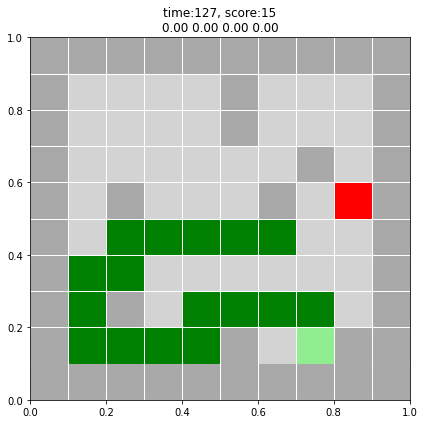

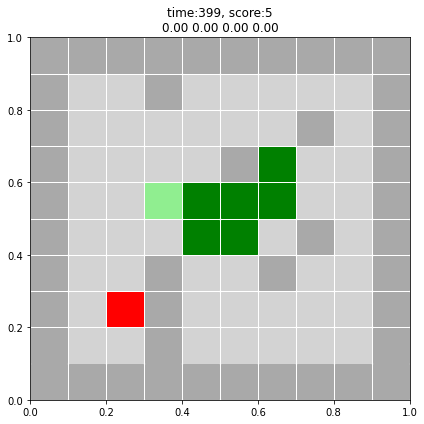

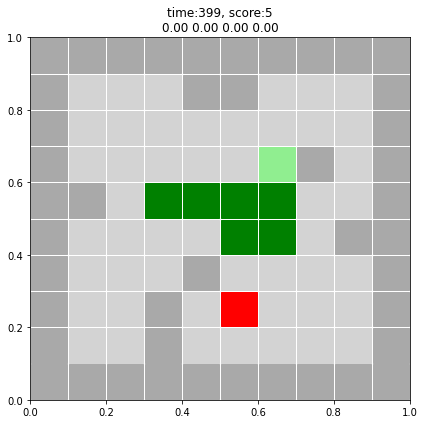

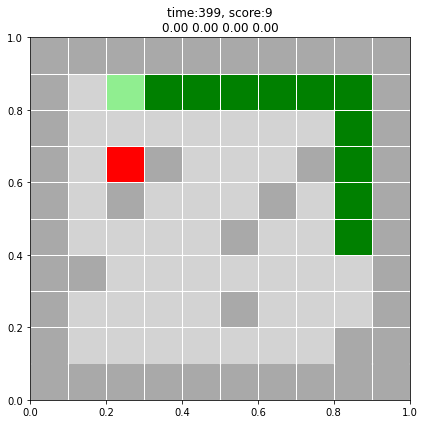

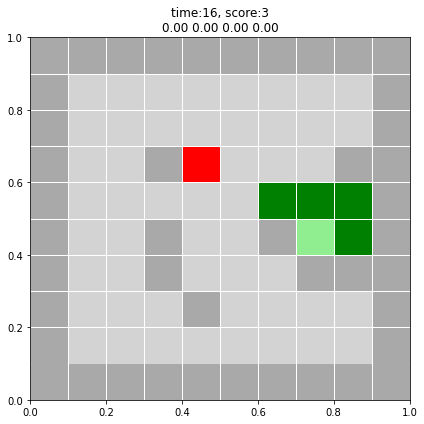

In [ ]:
'''
Script  to visualize how agent plays a game, useful to study different iterations
'''
import numpy as np
from agent import DeepQLearningAgent, PolicyGradientAgent, \
        AdvantageActorCriticAgent, HamiltonianCycleAgent, BreadthFirstSearchAgent
from game_environment import Snake, SnakeNumpy
from utils import visualize_game
import json
# import keras.backend as K

# some global variables
version = 'v17.1'

with open('model_config/{:s}.json'.format(version), 'r') as f:
    m = json.loads(f.read())
    board_size = m['board_size']
    frames = m['frames'] # keep frames >= 2
    max_time_limit = m['max_time_limit']
    supervised = bool(m['supervised'])
    n_actions = m['n_actions']
    obstacles = bool(m['obstacles'])

iteration_list = [163500]
max_time_limit = 398

# setup the environment
env = Snake(board_size=board_size, frames=frames, max_time_limit=max_time_limit,
            obstacles=obstacles, version=version)
s = env.reset()
n_actions = env.get_num_actions()

# setup the agent
# K.clear_session()
agent = DeepQLearningAgent(board_size=board_size, frames=frames, 
                           n_actions=n_actions, buffer_size=10, version=version)
# agent = PolicyGradientAgent(board_size=board_size, frames=frames, n_actions=n_actions, buffer_size=10)
# agent = AdvantageActorCriticAgent(board_size=board_size, frames=frames, n_actions=n_actions, buffer_size=10)
# agent = HamiltonianCycleAgent(board_size=board_size, frames=frames, n_actions=n_actions, buffer_size=10)
# agent = BreadthFirstSearchAgent(board_size=board_size, frames=frames, n_actions=n_actions, buffer_size=10)

for iteration in iteration_list:
    agent.load_model(file_path='models/{:s}'.format(version), iteration=iteration)
    
    for i in range(5):
        visualize_game(env, agent,
            path='images/game_visual_{:s}_{:d}_14_ob_{:d}.mp4'.format(version, iteration, i),
            debug=False, animate=True, fps=12)